In [ ]:
#https://github.com/pdichone/advanced-rag-techniques.git

## Начальная настройка:
подготовка необходимых библиотек. Это займёт несколько минут. \\
После их загрузки надо будет сделать рестарт сессии

In [ ]:
!pip install  chromadb pypdf langchain langchain-community langchain-text-splitters sentence-transformers


Попробуйте несколько разных вопросов, посмотрите, как модель выбирает ответы:

###Загрузка данных:

Теперь попробуем c реальным документом. Мы загрузим годовой финансовый отчет для акционеров корпорации Microsoft в формате PDF-документа

ваш URL-адрес для совместного использования документа на Google Drive выглядит примерно так:

`https://drive.google.com/file/d/`**1LDRlyZaZTF-bxHjBDEiL2obMxYHtf3YT**`/view?usp=sharing`

отсюда надо извлечь идентификатор файла, часть между /d/ и /view, и поместить его в новый URL-адрес, который выглядит так:

`https://drive.google.com/uc?export=download&id=`**1LDRlyZaZTF-bxHjBDEiL2obMxYHtf3YT**

Извлечем из PDF текст, и посмотрим на первую страницу

In [ ]:
def word_wrap(text, width=87):
    """
    Форматирует текст на указанную ширину.

    Args:
    text (str): Текст для форматирования.
    width (int): Новая ширина текста.

    Returns:
    str: форматированный текст.
    """
    return "\n".join([text[i : i + width] for i in range(0, len(text), width)])



with open("Особые преимущества.txt", "r") as file:
  texts = file.readlines()


# Filter the empty strings
texts = [text for text in texts if len(text) > 2]
print(
    word_wrap(
        texts[0],
        width=100,
    )
)

Особые права и преимущества. Бакалавриат



Подключим модель OpenAI

In [ ]:
from openai import OpenAI
import numpy as np
import chromadb
import pandas as pd


from google.colab import userdata
openai_api_key = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key)




In [ ]:
client.models.list()

SyncPage[Model](data=[Model(id='gpt-4o-mini-audio-preview-2024-12-17', created=1734115920, object='model', owned_by='system'), Model(id='dall-e-3', created=1698785189, object='model', owned_by='system'), Model(id='dall-e-2', created=1698798177, object='model', owned_by='system'), Model(id='gpt-4o-audio-preview-2024-10-01', created=1727389042, object='model', owned_by='system'), Model(id='gpt-4o-audio-preview', created=1727460443, object='model', owned_by='system'), Model(id='gpt-4o-mini-realtime-preview-2024-12-17', created=1734112601, object='model', owned_by='system'), Model(id='gpt-4o-mini-realtime-preview', created=1734387380, object='model', owned_by='system'), Model(id='o1-mini-2024-09-12', created=1725648979, object='model', owned_by='system'), Model(id='o1-mini', created=1725649008, object='model', owned_by='system'), Model(id='omni-moderation-latest', created=1731689265, object='model', owned_by='system'), Model(id='gpt-4o-mini-audio-preview', created=1734387424, object='model

###Разбиение данных на части:

Разделим текст на более мелкие фрагменты с использованием инструментов RecursiveCharacterTextSplitter и SentenceTransformersTokenTextSplitter из **Langchain** *. \\

Этот шаг гарантирует, что текст разбит на управляемые сегменты, учитывая ограничения по размеру токенов больших языковых моделей
___________________________________
**LangChain** — это фреймворк (библиотека) с открытым исходным кодом, предназначенный для упрощения разработки приложений, использующих большие языковые модели (LLM), такие как GPT-3, LLaMa, и другие. Он предоставляет инструменты для соединения LLM с различными источниками данных (базы данных, API, документы) и позволяет создавать цепочки (chains) последовательных вызовов LLM и других компонентов, реализуя сложные сценарии взаимодействия.

По сути, LangChain помогает "подружить" мощь языковых моделей с внешним миром и вашими данными.

In [ ]:
# Разделение текста на более мелкие фрагменты

from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""], chunk_size=1000, chunk_overlap=0
)
character_split_texts = character_splitter.split_text("\n\n".join(texts))



### Токенизация фрагментов текста

In [ ]:
token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0, tokens_per_chunk=256
)
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)
# выведем один chunk
print("Один из отрывков текста:\n", word_wrap(token_split_texts[10]))
print(f"\nВсего отрывков: {len(token_split_texts)}")


Один из отрывков текста:
 4. для приема на обучение лиц, имеющих право на прием без вступительных испытании в соо
тветствии с частью 4 статьи 71 федерального закона n 273 - фз, агу им. в. н. татищева и
 филиал : устанавливают соответствие конкурсных профилеи ( образовательных программ, сп
ециальностеи, направлении подготовки, совокупностеи

Всего отрывков: 31


### Генерация эмбеддингов из полученных токенов
Генерация embeddings для каждого текстового фрагмента с использованием функции [sentence transformer embedding](https://docs.trychroma.com/docs/embeddings/embedding-functions)

**Эмбеддинги** — это способ представления любых данных, в виде векторов многомерного пространства, что делает их идеальными для работы со всеми видами инструментов и алгоритмов на основе ИИ. Эмбеддинги могут представлять текст, изображения, аудио и видео. Существует множество вариантов создания эмбеддингов, как локально с использованием установленной библиотеки, так и путем вызова API.

Библиотека **ChromaDB** * предоставляет легкие оболочки вокруг популярных поставщиков эмбеддингов, что упрощает их использование в ваших приложениях. Вы можете задать эмбеддинг-функцию при создании коллекции Chroma, которая будет использоваться автоматически, или можете вызывать их напрямую самостоятельно.
________________________________
**ChromaDB** — это векторная база данных с открытым исходным кодом, предназначенная для хранения и быстрого поиска векторных представлений (эмбеддингов) данных, что делает её полезной для задач, связанных с искусственным интеллектом, таких как семантический поиск и рекомендательные системы. Она оптимизирована для работы с высокоразмерными данными и позволяет находить ближайшие векторы по сходству.

####Аналоги ChromaDB:

**FAISS** (Facebook AI Similarity Search): Библиотека от Facebook, специализирующаяся на эффективном поиске сходства и кластеризации плотных векторов.

**Pinecone**: Управляемая векторная база данных, предлагающая масштабируемость и простоту использования через API.

**Weaviate**: Векторная поисковая система с открытым исходным кодом, поддерживающая семантический поиск, классификацию изображений и многое другое.

**Milvus**: База данных векторного поиска с открытым исходным кодом, разработанная для масштабируемости и производительности.

**Qdrant**: Векторная поисковая система и векторная база данных, предлагает удобный API со множеством дополнительных функций


In [ ]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
# выведем один эмбеддинг
em = embedding_function([token_split_texts[10]])

print("Эмбеддинг одного из отрывков:\n", em)
print(np.array(em).shape)

Эмбеддинг одного из отрывков:
 [array([ 1.86110828e-02, -3.99156101e-02, -7.29644075e-02, -7.55462376e-03,
       -8.14066380e-02,  3.88432965e-02,  2.76802387e-02,  4.15999629e-02,
       -9.65302438e-03,  2.45976765e-02, -1.89577229e-02,  6.03193007e-02,
        3.60283852e-02,  4.80087250e-02,  2.50687450e-02, -3.71714458e-02,
       -8.47402029e-03,  2.31298935e-02, -2.72870250e-03, -4.15218621e-03,
        3.05089001e-02, -3.79448682e-02,  1.07354119e-01, -4.05953601e-02,
        5.66963516e-02, -5.20912819e-02, -2.56003737e-02, -6.32721856e-02,
        1.83219723e-02,  7.19320625e-02, -2.35845186e-02, -3.16286855e-03,
        1.03453711e-01, -5.08052558e-02, -7.00228964e-04, -5.97976781e-02,
        5.47678098e-02, -6.06133277e-03, -1.61711348e-03,  1.25590712e-01,
       -6.64787740e-02,  2.66229734e-02, -1.00849055e-01,  4.21291180e-02,
       -5.27381264e-02,  3.33099663e-02, -7.50783086e-02, -4.46675858e-03,
       -6.97162971e-02, -6.26312345e-02,  5.22918254e-03,  4.4946938

In [ ]:
# Настройка векторной базы данных:

# Инициализация клиента ChromaDB
chroma_client = chromadb.Client()
# создание коллекции для хранения текстовых фрагментов и соответствующих embeddings.
chroma_collection = chroma_client.create_collection(
    "priem", embedding_function=embedding_function
)
# Добавление текстовых фрагментов и embeddings в коллекцию ChromaDB
# Так мы создаем векторное хранилище

ids = [str(i) for i in range(len(token_split_texts))]
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()


31

### Обработка запросов:
Посмотрим пример входного запроса и передачи его в большую языковую модель для поиска подходящего фрагмента в заданном тексте.

В этом примере запрос снабжается системным промптом, в котором задаётся роль модели и паттерн желаемого ответа.

Это будет "гипотетический" ответ, придуманный моделью и не имеющий отношения к реальному документу

In [ ]:
import umap
original_query ="Какие условия поступления для сирот?"

def augment_query_generated(query, model="gpt-4o-mini"):#"gpt-3.5-turbo"
    prompt = """Вы секретарь приемной коммисии.
   Приведите пример ответа на этот вопрос, который можно найти в таком документе, как особые правила приема."""
    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

def project_embeddings(embeddings, umap_transform):
    """
    Проецирует полученные эмбеддинги с использованием предоставленного трансформера UMAP.

    Аргументы:
    embeddings (numpy.ndarray): эмбеддинги для проецирования.
    umap_transform (umap.UMAP): обученный трансформер UMAP.

    Возвращает:
    numpy.ndarray: спроецированные эмбеддинги.
    """
    projected_embeddings = umap_transform.transform(embeddings)
    return projected_embeddings



hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query}\n\n {hypothetical_answer}"
print(word_wrap(joint_query))

results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"][0]


# for doc in retrieved_documents:
#     print(word_wrap(doc))
#     print("")

embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)


retrieved_embeddings = results["embeddings"][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(
    original_query_embedding, umap_transform
)
projected_augmented_query_embedding = project_embeddings(
    augmented_query_embedding, umap_transform
)
projected_retrieved_embeddings = project_embeddings(
    retrieved_embeddings, umap_transform
)


Какие условия поступления для сирот?

 Условия поступления для сирот могут быть указаны
 в специальных правилах приема. Например, в некоторых учебных заведениях для сирот пред
усмотрены следующие льготы и особенности:

1. **Приоритетное право на поступление** – с
ироты могут иметь преимущество при зачислении на бюджетные места.
   
2. **Дополнительн
ые баллы** – в зависимости от региона или учебного заведения, сироты могут получать доп
олнительные баллы к результатам экзаменов.

3. **Социальные льготы** – предоставление б
есплатного общежития, стипендий или пособий на обучение.

4. **Обработка документов** –
 упрощенный порядок подачи документов или дополнительные консультации по вопросам посту
пления.

Рекомендуется уточнить актуальную информацию в индивидуальном учебном заведени
и или ознакомиться с официальными правилами приема на их сайте.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Посмотрите, как выглядит проекция многомерного семантического пространства.
* **Серые точки** - эмбеддинги документа
* **Зеленые кружки** - эмбеддинги фрагментов текста, извлеченные по запросу
* **красные крестики** - эмбеддинги исходного запроса
* **оранжевые крестики** - эмбеддинги расширенного запроса. \
Они должны попасть в область, наиболее близкую к извлеченным эмбеддингам. Здесь может использоваться быстрый алгоритм кластеризации, например k-means

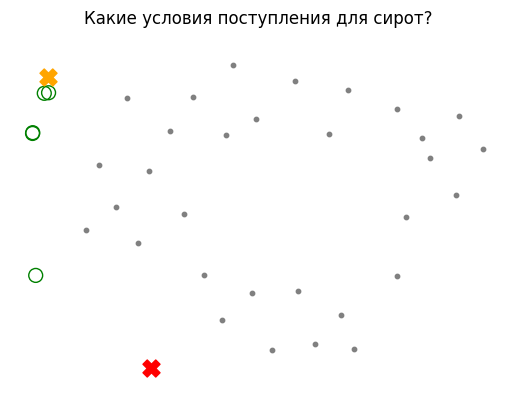

In [ ]:

import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()

plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
)
plt.scatter(
    projected_retrieved_embeddings[:, 0],
    projected_retrieved_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
)
plt.scatter(
    projected_original_query_embedding[:, 0],
    projected_original_query_embedding[:, 1],
    s=150,
    marker="X",
    color="r",
)
plt.scatter(
    projected_augmented_query_embedding[:, 0],
    projected_augmented_query_embedding[:, 1],
    s=150,
    marker="X",
    color="orange",
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.show()  # display the plot

### Генерация ответа
Теперь попробуем использовать извлеченные из нашего документа отрывки для более точного ответа на вопрос.

* Передача извлеченных документов и исходного запроса большой языковой модели для создания окончательного ответа.
* Языковая модель использует извлеченные отрывки как контекст для предоставления обоснованного ответа

In [ ]:
original_query = "Какие условия поступления для сирот?"


def generate_multi_query(query, model="gpt-4o-mini"):#gpt-3.5-turbo"

    prompt = """
    Вы секретарь приемной коммисии.
    Ваши пользователи интересуются правилами поступления.
    Для данного вопроса предложите до трех связанных вопросов, чтобы помочь им найти необходимую информацию.
    Задавайте краткие однотематические вопросы (без составных предложений), которые охватывают различные аспекты темы.
    Убедитесь, что каждый вопрос является полным и напрямую связан с исходным запросом.
    Каждый вопрос записывайте на отдельной строке без нумерации.
    Все результаты пишите на языке вопроса.
    """

    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content



aug_queries = generate_multi_query(original_query)

# 1. Первый шаг — показать расширенные запросы
for query in aug_queries:
    print("\n", query)

# 2. объединить исходный запрос с дополненными запросами
# Исходный запрос находится в списке.
# Мы добавляем его в список, так как chroma может обрабатывать несколько запросов
joint_query = [
    original_query
] + aug_queries

# print("======> \n\n", joint_query)

results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"]

# Удаляем дубликаты извлеченных документов
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)


# выводим результирующие документы
for i, documents in enumerate(retrieved_documents):
    print(f"Query: {joint_query[i]}")
    print("")
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print("")
    print("-" * 100)

embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)




 Какие документы нужны для поступления сирот?  

 Существуют ли льготы для сирот при поступлении?  

 Есть ли особые квоты для сирот в приемной комиссии?  
Query: Какие условия поступления для сирот?

Results:
##ов по общеобразовательному вступительному испытанию или по дополнительному вступитель
ному испытанию ( испытаниям ) ( далее - особое преимущество ).

поступающего ) из числа предметов, установленных агу им. в. н. татищева и филиалом.

##тивным достижениям ;

##льзовать одно и то же основание для получения права на 100 баллов ( особого преимущес
тва ) по одному и тому же вступительному испытанию ( предмету ) или по различным вступи
тельным испытаниям ( предметам ). 7. поступающим предоставляются особые права :

##сному профилю в целом.

----------------------------------------------------------------------------------------------------
Query: Какие документы нужны для поступления сирот?  

Results:
##тивным достижениям ;

##ов по общеобразовательному вступительному испытанию ил

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Мы также можем визуализировать результаты в пространстве эмбеддингов.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


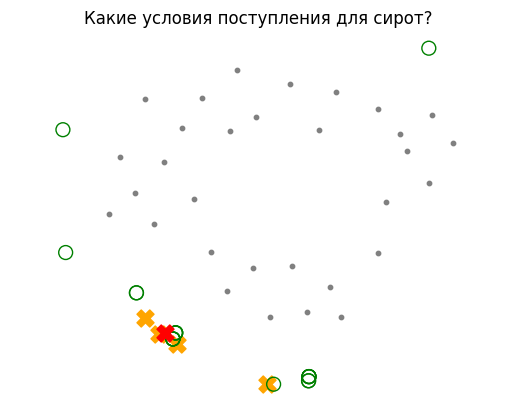

In [ ]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(joint_query)


project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(
    augmented_query_embeddings, umap_transform
)

retrieved_embeddings = results["embeddings"]
result_embeddings = [item for sublist in retrieved_embeddings for item in sublist]

projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
)
plt.scatter(
    project_augmented_queries[:, 0],
    project_augmented_queries[:, 1],
    s=150,
    marker="X",
    color="orange",
)
plt.scatter(
    projected_result_embeddings[:, 0],
    projected_result_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
)
plt.scatter(
    project_original_query[:, 0],
    project_original_query[:, 1],
    s=150,
    marker="X",
    color="r",
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.show()  # display the plot

дополненные эмбеддинги (оранжевые кресты) здесь оказываются между исходным вопросом и извлеченными документами. На плоской проекции многомерного пространства это не всегда очевидно, но представьте себе, что это 384-мерное пространство,

In [ ]:
joint_query

['Какие условия поступления для сирот?',
 'Какие документы нужны для поступления сирот?  ',
 'Существуют ли льготы для сирот при поступлении?  ',
 'Есть ли особые квоты для сирот в приемной комиссии?  ']

### Оценка релевантности извлеченных отрывков и выбор лучших:

Нам надо выбрать отрывки из наших документов, наиболее подходящие в качестве  ответа на заданный вопрос.
####Здесь мы будем использовать **CrossEncoder**.
CrossEncoder принимает два предложения/текста в качестве входных данных и предсказывает, насколько вероятно, что это вопрос-ответ. Эта задача использовалась на стадии pretrain моделей BERT, поэтому качество предсказаний должно быть высоким



In [ ]:
from sentence_transformers import CrossEncoder


cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

flat_retrieved_documents = [doc for sublist in retrieved_documents for doc in sublist]

pairs = [(query, doc) for doc in flat_retrieved_documents]
scores = cross_encoder.predict(pairs)

# print("Scores:")
# for score in scores:
#     print(score)

# print("New Ordering:")
# for o in np.argsort(scores)[::-1]:
#     print(o + 1)

original_query = joint_query[0]
#    "Какие факторы были наиболее важными, способствовавшими увеличению доходов?"


generated_queries = joint_query[1:]
    # "What were the major drivers of revenue growth?",
    # "Were there any new product launches that contributed to the increase in revenue?",
    # "Did any changes in pricing or promotions impact the revenue growth?",
    # "What were the key market trends that facilitated the increase in revenue?",
    # "Did any acquisitions or partnerships contribute to the revenue growth?",


# объединим исходный вопрос с созданными вопросами
queries = [original_query] + generated_queries


results = chroma_collection.query(
    query_texts=queries, n_results=10, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"]

# Удалим дубликаты извлеченных документов
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

unique_documents = list(unique_documents)

# составляем пары исходный вопрос - документ
# с каждым извлеченным документом
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

# вычисляем показатели близости между исходным вопросом и каждым документом
scores = cross_encoder.predict(pairs)



# print("New Ordering:")
# for o in np.argsort(scores)[::-1]:
#     print(o)
# ====
# Отбираем пять самых близких к исходному вопросу документов
top_indices = np.argsort(scores)[::-1][:5]
top_documents = [unique_documents[i] for i in top_indices]

# Объединим пять самых близких документов в единый контекст
context = "\n\n".join(top_documents)


# Генерируем окончательный ответ с использованием LLM
def generate_multi_query(query, context, model='gpt-4o-mini'):

    prompt = f"""
    Вы секретарь приемной коммисии.
    Приведите пример ответа на этот вопрос, который можно найти в таком документе, как особые правила приема.
    """

    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {
            "role": "user",
            "content": f"Основываясь на следующем контексте:\n\n{context}\n\n Ответье на вопрос: '{query}'. Все ответы должны быть на языке вопроса",
        },
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    # content = content.split("\n")
    return content


res = generate_multi_query(query=original_query, context=context)
print("Исходный вопрос:", original_query)

print("Финальный ответ:")
from IPython.display import Markdown
Markdown(res)

Исходный вопрос: Какие условия поступления для сирот?
Финальный ответ:


Согласно особым правилам приема, сироты имеют право на особые условия поступления, включая возможность подачи заявления только в одну организацию и на одну образовательную программу по выбору. Им также может быть предоставлено право на 100 баллов (особое преимущество) за успешное выполнение вступительных испытаний. Дополнительные права могут включать возможность поступления без вступительных испытаний в случае установления соответствия конкурсных профилей с профилями олимпиад. Эти меры направлены на поддержку поступающих, относящихся к категории сирот, и обеспечение равных возможностей для получения образования.